In [1]:
import warnings

import pymc3 as pm
import numpy as np
import arviz as az
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


warnings.filterwarnings("ignore")

In [59]:
plt.rcParams['font.size'] = '10'
plt.style.use('fivethirtyeight')

In [204]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14

## Data

In [3]:
data = pd.read_csv("../data/heart.csv")

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.Sex = data.Sex.replace({'M':0, 'F':1})
data.ExerciseAngina = data.ExerciseAngina.replace({'N':0, 'Y':1})
data.ST_Slope = data.ST_Slope.replace({'Up':1, 'Flat':0, 'Down':-1})
data.RestingECG = data.RestingECG.replace({'ST':1, 'Normal':0, 'LVH':-1})
data.ChestPainType = data.ChestPainType.replace({'NAP':0, 'ASY':1, 'TA':2, 'ATA':3})

In [5]:
X = data.drop('HeartDisease', axis=1)
y = data.HeartDisease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

labels = X_train.columns

## Bayesian Logistic Regression

In [6]:
%%time

lower = -10**6
higher = 10**6

with pm.Model() as first_model:
    #priors on parameters
    beta_0 = pm.Uniform('beta_0', lower=lower, upper=higher)
    beta_age = pm.Uniform('beta_age', lower=lower, upper=higher)
    beta_sex = pm.Uniform('beta_sex', lower=lower, upper=higher)
    beta_chestpaintype = pm.Uniform('beta_chestpaintype', lower=lower, upper=higher)
    beta_restingbp = pm.Uniform('beta_restingbp', lower=lower, upper=higher)
    beta_cholesterol = pm.Uniform('beta_cholesterol', lower=lower, upper=higher)
    beta_fastingbs = pm.Uniform('beta_fastingbs', lower=lower, upper=higher)
    beta_restingecg = pm.Uniform('beta_restingecg', lower=lower, upper=higher)
    beta_maxhr = pm.Uniform('beta_maxhr', lower=lower, upper=higher)
    beta_exerciseangina = pm.Uniform('beta_exerciseangina', lower=lower, upper=higher)
    beta_oldpeak = pm.Uniform('beta_oldpeak', lower=lower, upper=higher)
    beta_st_slope = pm.Uniform('beta_st_slope', lower=lower, upper=higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic(
        'p', 
        pm.math.sigmoid(
            beta_0+
            beta_age*data['Age']+
            beta_sex*data['Sex']+
            beta_chestpaintype*data['ChestPainType']+
            beta_restingbp*data['RestingBP']+
            beta_cholesterol*data['Cholesterol']+
            beta_fastingbs*data['FastingBS']+
            beta_restingecg*data['RestingECG']+
            beta_maxhr*data['MaxHR']+
            beta_exerciseangina*data['ExerciseAngina']+
            beta_oldpeak*data['Oldpeak']+
            beta_st_slope*data['ST_Slope']
        )
    )
 
    observed = pm.Bernoulli("disease", p, observed=data['HeartDisease'])
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace = pm.sample(25000, step=step, start=start)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_st_slope]
>Metropolis: [beta_oldpeak]
>Metropolis: [beta_exerciseangina]
>Metropolis: [beta_maxhr]
>Metropolis: [beta_restingecg]
>Metropolis: [beta_fastingbs]
>Metropolis: [beta_cholesterol]
>Metropolis: [beta_restingbp]
>Metropolis: [beta_chestpaintype]
>Metropolis: [beta_sex]
>Metropolis: [beta_age]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 1min 35s, sys: 5.04 s, total: 1min 40s
Wall time: 3min 16s


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


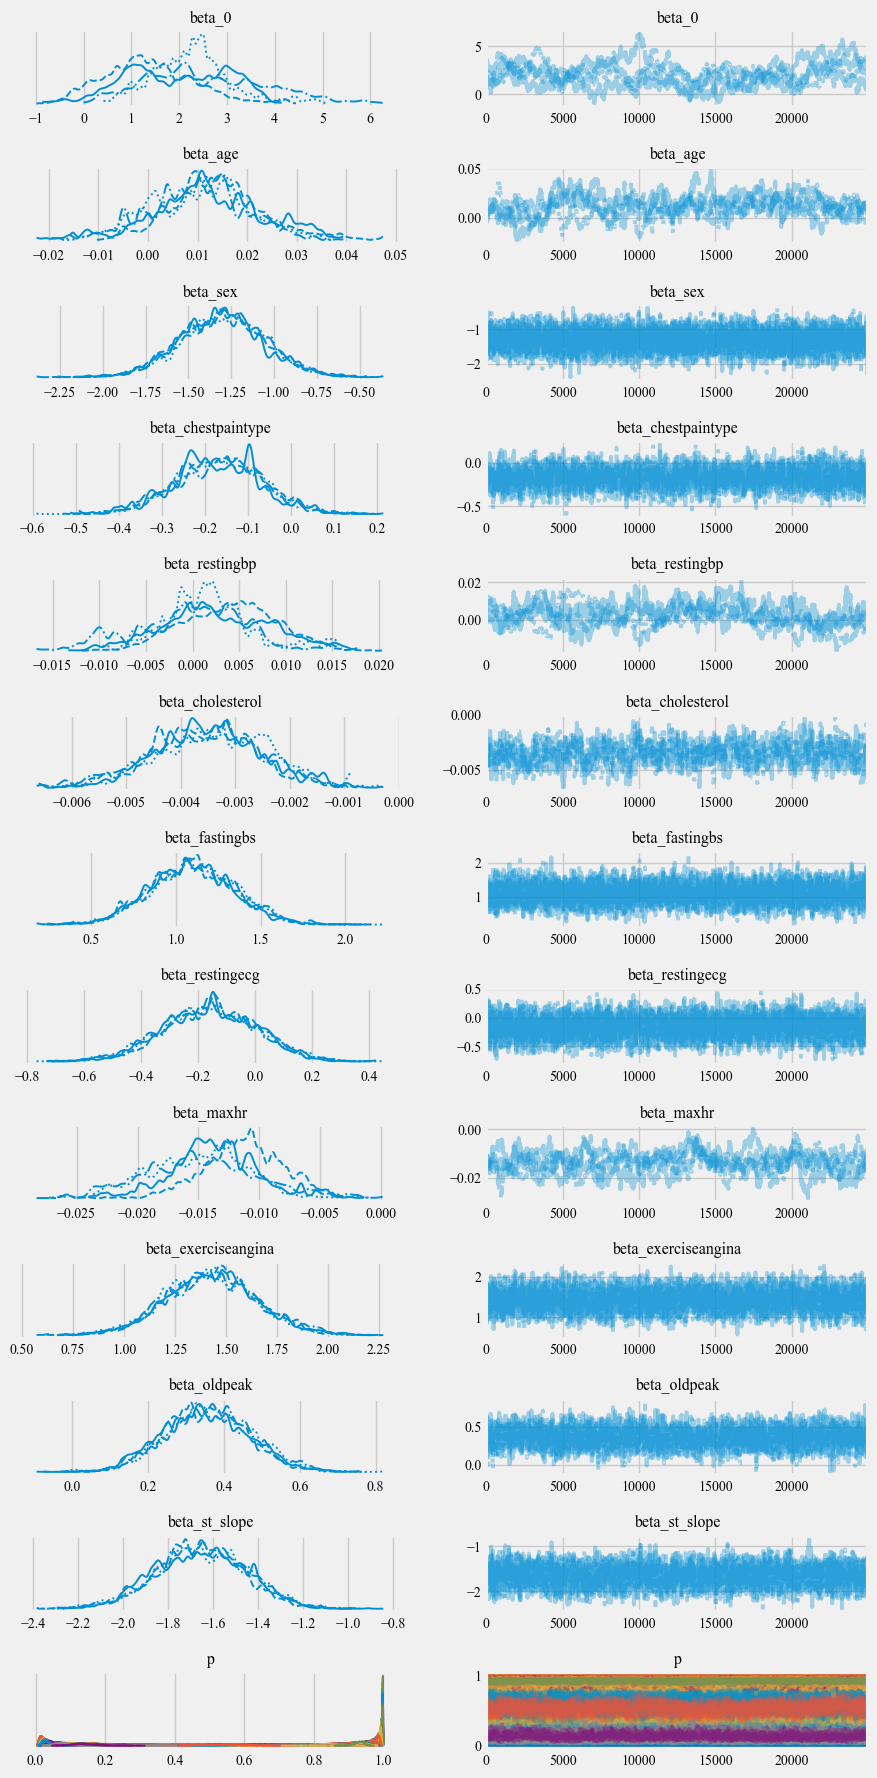

In [77]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14

out = pm.plot_trace(trace, figsize=(9, 18), plot_kwargs={"lw":1.4})

plt.tight_layout()

In [67]:
az.rhat(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


<xarray.Dataset>
Dimensions:              (p_dim_0: 918)
Coordinates:
  * p_dim_0              (p_dim_0) int64 0 1 2 3 4 5 ... 912 913 914 915 916 917
Data variables: (12/13)
    beta_0               float64 1.123
    beta_age             float64 1.042
    beta_sex             float64 1.001
    beta_chestpaintype   float64 1.002
    beta_restingbp       float64 1.07
    beta_cholesterol     float64 1.009
    ...                   ...
    beta_restingecg      float64 1.003
    beta_maxhr           float64 1.074
    beta_exerciseangina  float64 1.002
    beta_oldpeak         float64 1.003
    beta_st_slope        float64 1.002
    p                    (p_dim_0) float64 1.01 1.024 1.029 ... 1.011 1.015

In [69]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=first_model)
np.asarray(ppc['disease']).shape

(1000, 918)

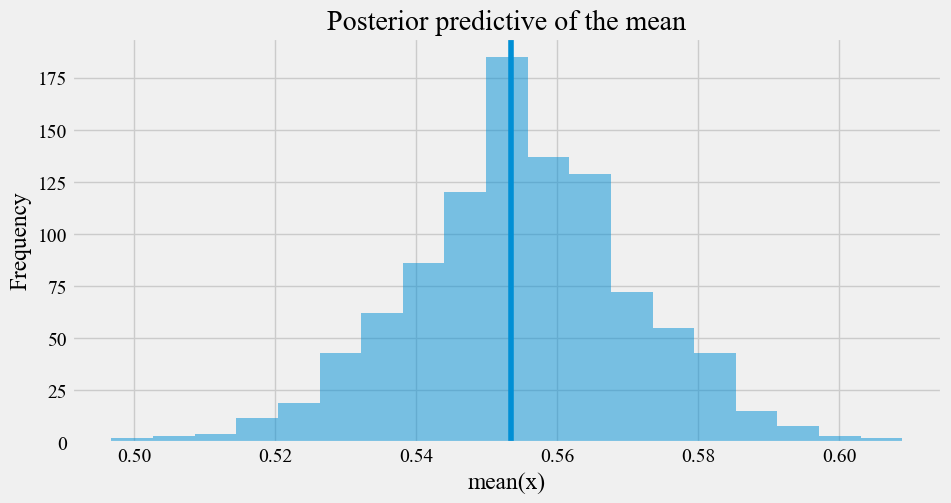

In [72]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['disease']], bins=19, alpha=0.5)
ax.axvline(data.HeartDisease.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

## Evaluation

In [7]:
def predict_posterior(trace, X):
    X = X.copy()
    coef_samples = pd.DataFrame(
        {
            'intercept': trace['beta_0'],
            'age': trace['beta_age'],
            'sex': trace['beta_sex'],
            'chest_pain_type': trace['beta_chestpaintype'],
            'resting_bp': trace['beta_restingbp'],
            'cholesterol': trace['beta_cholesterol'],
            'fasting_bs': trace['beta_fastingbs'],
            'resting_ecg': trace['beta_restingecg'],
            'max_hr': trace['beta_maxhr'],
            'exercise_angina': trace['beta_exerciseangina'],
            'old_peak': trace['beta_oldpeak'],
            'st_slope': trace['beta_st_slope'],
        }
    )
    
    X.insert(0, "intercept", 1)
    linear_combinations = np.matmul(coef_samples, X.T)
    probabilities = 1 / (1 + np.exp(-linear_combinations))

    return probabilities

In [8]:
posterior = predict_posterior(trace, X_test)
posterior.shape

(100000, 184)

<Axes: ylabel='Density'>

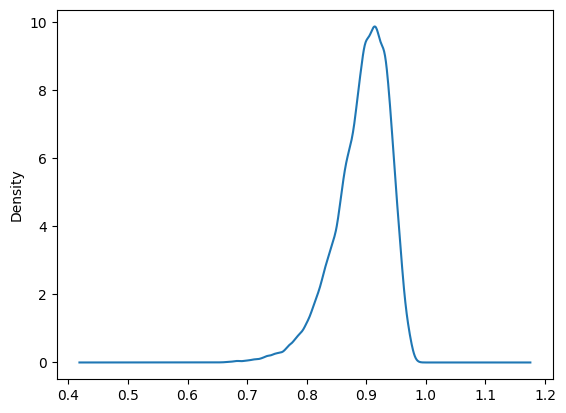

In [9]:
posterior[35].plot(kind='kde')

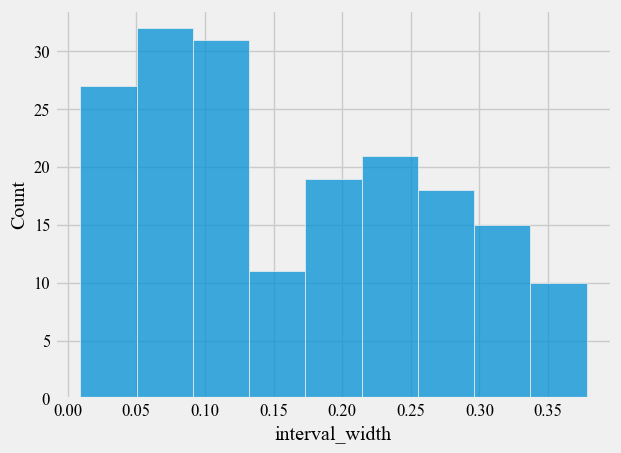

In [81]:
bound = az.hdi(posterior.values, hdi_prob=.95)

result = pd.DataFrame(dict(
    lb=bound[:,0],
    ub=bound[:,1],
    pred_proba=posterior.mean(),
    pred_class=(posterior.mean() > .5).astype(int),
    interval_width=bound[:,1]-bound[:,0],
    y_true=y_test.values
))


mpl.rcParams['font.size'] = 12

sns.histplot(result.interval_width);

In [99]:
accuracy_score(result.y_true, result.pred_class)

0.8369565217391305

In [100]:
accuracy_list = list()

for t in np.arange(0, 1, .01):
    reliable = result.loc[result.interval_width < t]
    
    accuracy_list.append(accuracy_score(
        reliable.y_true, reliable.pred_class
    ))

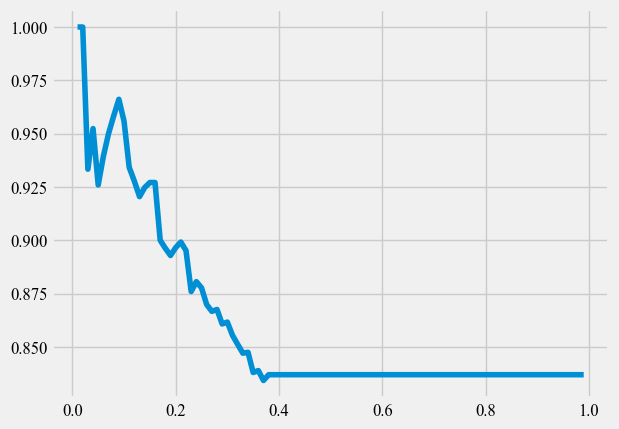

In [101]:
plt.plot(np.arange(0, 1, .01), accuracy_list);

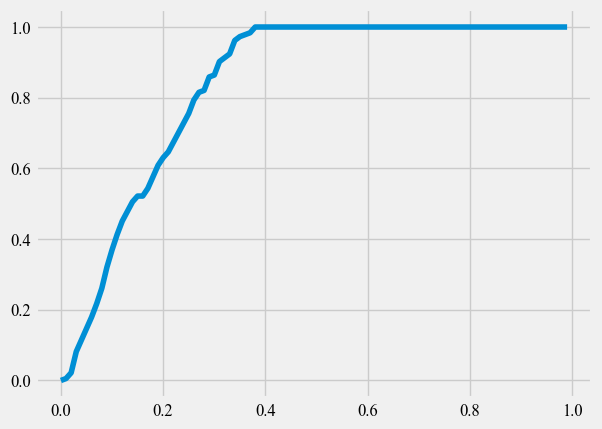

In [102]:
certainty_size = list()

for t in np.arange(0, 1, .01):
    reliable = result.loc[result.interval_width < t]
    
    certainty_size.append(
        reliable.shape[0] / result.shape[0]
    )
    
plt.plot(np.arange(0, 1, .01), certainty_size);

In [103]:
reliable = result.loc[result.interval_width < .0885]
print("Size:", reliable.shape[0] / result.shape[0])
print("Accuracy:", accuracy_score(reliable.y_true, reliable.pred_class))

Size: 0.30434782608695654
Accuracy: 0.9642857142857143


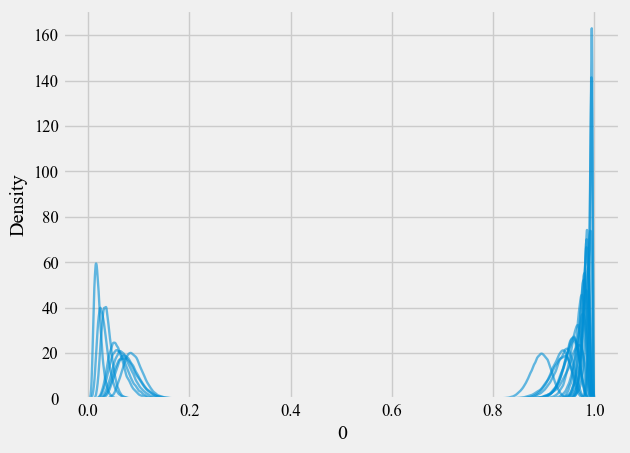

In [110]:
for i in reliable.index[:30]:
    sns.kdeplot(posterior[i], color="#008FD5", lw=1.7, alpha=.6);

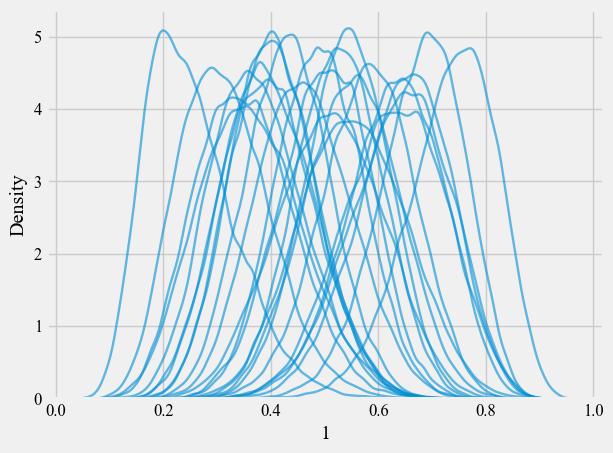

In [111]:
uncertain = result.loc[result.interval_width > .3]

for i in uncertain.index[:30]:
    sns.kdeplot(posterior[i], color="#008FD5", lw=1.7, alpha=.6);

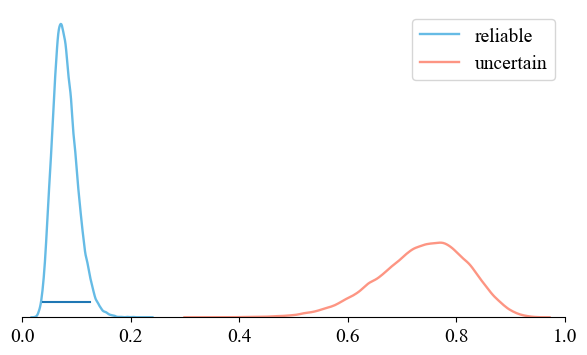

In [236]:
plt.figure(figsize=(7, 4))
sns.kdeplot(posterior[reliable.index[2]], color=colors[0], lw=1.7, alpha=.6, fill=False, label="reliable");
sns.kdeplot(posterior[uncertain.index[12]], color=colors[1], lw=1.7, alpha=.6, fill=False, label="uncertain");

plt.xlim([0, 1]);
plt.ylabel("");
plt.xlabel("");
plt.yticks([]);
plt.legend();

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

_ = plt.grid(False)

plt.axhline(y=1, xmin=0.038, xmax=0.125);

In [200]:
plt.rcdefaults()

In [37]:
reliable = result.loc[result.interval_width < .14]
print("Size:", reliable.shape[0] / result.shape[0])
print("Accuracy:", accuracy_score(reliable.y_true, reliable.pred_class))

Size: 0.5054347826086957
Accuracy: 0.9247311827956989


In [39]:
reliable = result.loc[result.interval_width < .23]
print("Size:", reliable.shape[0] / result.shape[0])
print("Accuracy:", accuracy_score(reliable.y_true, reliable.pred_class))

Size: 0.7010869565217391
Accuracy: 0.875968992248062


In [132]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

### Alternative

In [ ]:
reliable = result.loc[result.interval_width < .0885]
print("Size:", reliable.shape[0] / result.shape[0])
print("Accuracy:", accuracy_score(reliable.y_true, reliable.pred_class))

<Axes: ylabel='Frequency'>

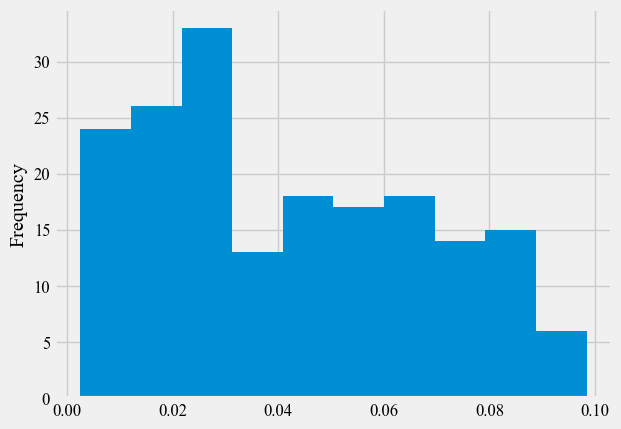

In [150]:
posterior.std().plot(kind="hist")

In [151]:
result = result.assign(posterior_std=posterior.std())

In [159]:
reliable = result.loc[result.posterior_std < .0233]
print("Size:", reliable.shape[0] / result.shape[0])
print("Accuracy:", accuracy_score(reliable.y_true, reliable.pred_class))

Size: 0.30978260869565216
Accuracy: 0.9649122807017544
